In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
nyc_weekly = pd.read_csv('nyc_weekly')

In [3]:
nyc_weekly = nyc_weekly.drop(['Unnamed: 0'], axis=1)

In [4]:
nyc_weekly['log_counts'] = np.log(nyc_weekly['CRIME_SUM'])
nyc_weekly.head()

,Date,CRIME_SUM,log_counts
0,2007-12-31,2473.0,7.813187
1,2008-01-07,2320.0,7.749322
2,2008-01-14,2101.0,7.650169
3,2008-01-21,2160.0,7.677864
4,2008-01-28,2198.0,7.695303


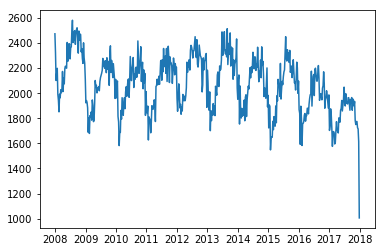

In [6]:
nyc_weekly['Date'] = pd.to_datetime(nyc_weekly['Date'])
plt.plot(nyc_weekly.Date, nyc_weekly.CRIME_SUM)
plt.show()

### Scale the data using MinMaxScaler

In [10]:
crime = nyc_weekly
scaler = MinMaxScaler()
crime_S = scaler.fit_transform(crime.iloc[:,1:2])
crime_S = pd.DataFrame(crime_S, columns=['CRIME_SUM'])

In [11]:
crime_S = pd.concat([crime.Date, crime_S], axis=1)
crime_S.head()

,Date,CRIME_SUM
0,2007-12-31,0.931429
1,2008-01-07,0.834286
2,2008-01-14,0.695238
3,2008-01-21,0.732698
4,2008-01-28,0.756825


### Create dataset for LSTM

In [13]:
def create_dataset(dataset, window_size):
    """
    Creates x and y data sets used for training the LSTM model in the format which is acceptable by Keras API
    Parameters:
        data : crime history (as numpy array)
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        x : Feature inputs
        y : Target labels
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        # Creating sets of data points (crime) to predict for next week
        data_X.append(dataset[i:(i + window_size), 1]) ## 1 - 'CRIME_SUM' crime from dataframe
        data_Y.append(dataset[i + window_size, 1])
    # Converting list to numpy array
    data_X = np.array(data_X)
    data_Y = np.array(data_Y)
    # Reshaping it according to LSTM input
    x = np.reshape(data_X, (data_X.shape[0], 1, data_X.shape[1]))
    y = np.reshape(data_Y, (data_Y.shape[0], 1, 1))
    return x, y

window_size = 26
x, y = create_dataset(crime_S.values, window_size)

In [17]:
print("number of weeks in the dataset:", crime_S.shape[0])
print("lets take 26 week for the window which makes almost half a year period")
print("confirm 10 year by dividing whole dataset to 2 half a year periods:", crime_S.shape[0]/ (26*2), "year.")

number of weeks in the dataset: 522
lets take 26 week for the window which makes almost half a year period
confirm 10 year by dividing whole dataset to 2 half a year periods: 10.038461538461538 year.


In [18]:
x.shape, y.shape

((495, 1, 26), (495, 1, 1))

### Create the model containing LSTM layers

Input shape of first 'LSTM' layer : (1, window_size)<br>
Output of final 'Dense' layer : 1

In [19]:
Y = y
Y  = np.reshape(Y, (Y.shape[0], 1))

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [24]:
def lstm_model(x, window_size):
    """
    Creates the model which will be used to forecast next week's crime number based on previous values as inputs
    Parameters:
        x : Feature inputs
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        model : Model architecture created using Keras
    """
    model = Sequential()
    model.add(LSTM(units=32, activation='relu', input_shape=(1, window_size)))    # the batch size is neglected!
    model.add(Dense(1))
    print (model.summary())
    return model

model = lstm_model(x, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                7552      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,585
Trainable params: 7,585
Non-trainable params: 0
_________________________________________________________________
None


### Compile the model

In [25]:
model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics = ['mse'])
model.fit(x=x, y=Y, batch_size=16, epochs=50)

Epoch 1/50
495/495 [==============================] - 2s 3ms/step - loss: 0.1386 - mean_squared_error: 0.1386
Epoch 2/50
495/495 [==============================] - 0s 361us/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 3/50
495/495 [==============================] - 0s 377us/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 4/50
495/495 [==============================] - 0s 371us/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 5/50
495/495 [==============================] - 0s 371us/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 6/50
495/495 [==============================] - 0s 396us/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 7/50
495/495 [==============================] - 0s 365us/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 8/50
495/495 [==============================] - 0s 354us/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 9/50
495/495 [==============================] - 0s 379us/step - loss: 0.0074 - mean_squared_error: 0

### Prediction

In [27]:
def predict(crimes, x, window_size, batch_size=16):
    """
    Uses trained model to predict on the input set, scales data back to original distribution
    and returns the original dataframe with an added column containing predictions
    
    Parameters:
        crimes : Original??? dataframe of crime numbers
        x : Feature inputs used to train the model
        batch_size : Batch_size used for training the model
    
    Returns:
        crime_pred : Crime numbers dataframe with an added column containing predictions made by the trained model
    """
    preds = []
    crimes.reset_index(drop=True, inplace=True)
    # Iterating over training samples
    for i in range(len(x)):
        data = np.reshape(x[i], (1, 1, 26))
        # Predicting from the trained model
        preds.append(model.predict(x=data, batch_size=batch_size)[0][0])

    predictions = np.copy(scaler.inverse_transform(np.array(preds).reshape(-1, 1)))
    crimes.loc[window_size+1:,'Predictions'] = np.copy(predictions)
    crimes.loc[:,'CRIME_SUM'] = np.copy(scaler.inverse_transform(crimes.loc[:,'CRIME_SUM'].values.reshape(-1, 1)))
    return crimes

crimes = predict(crime_S, x, window_size)

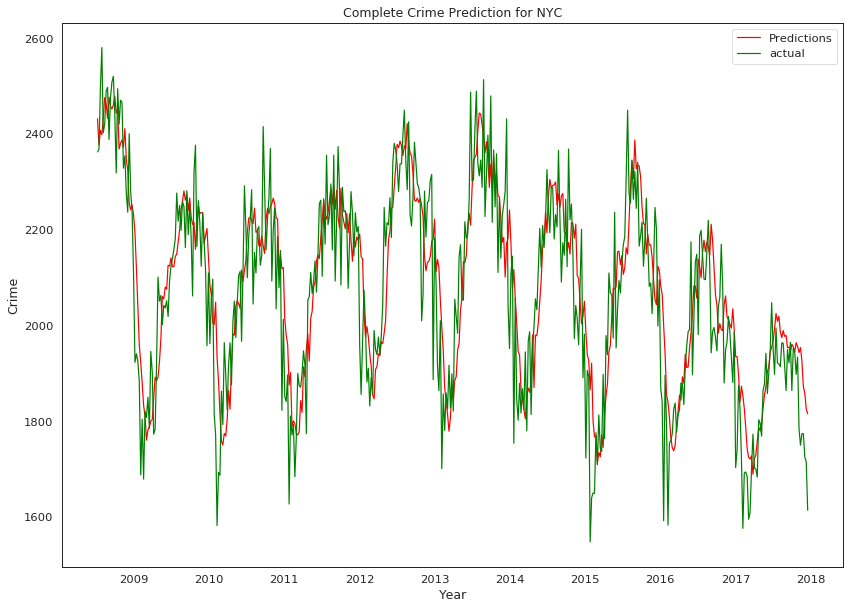

In [310]:
def plot_predictions(crimes, title, idx1=27, idx2=len(crimes)-1):
    """
    Plots the predictions on top of crime numbers history
    
    Parameters:
        crimes : Original dataframe of crime numbers
        title : Title of the plot
    
    Returns:
        crimes : Crime numbers dataframe with an added column containing predictions made by the trained model
    """
    plt.figure(figsize=(14, 10))
    plt.plot(crimes.Date[idx1:idx2], crimes.Predictions[idx1:idx2], label='Predictions', color='red')
    plt.plot(crimes.Date[idx1:idx2], crimes.CRIME_SUM[idx1:idx2], label='actual', color='green')
    plt.xlabel("Year")
    plt.ylabel("Crime")
    plt.title(title)
    plt.legend()
    plt.show()
        
title = "Complete Crime Prediction for NYC"
plot_predictions(crimes, title)

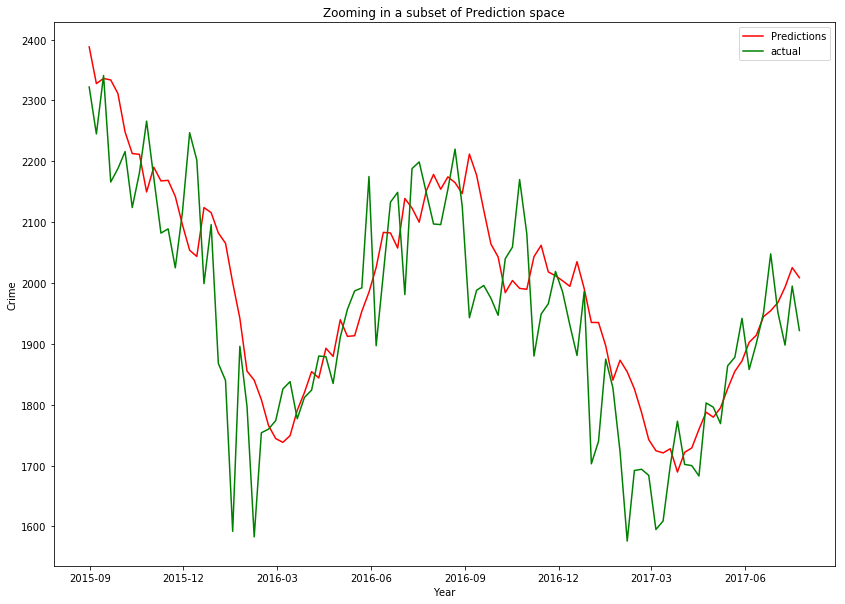

In [52]:
# Same function to zoom in on a particular sub-space of predictions
title = "Zooming in a subset of Prediction space"
plot_predictions(crimes, title, 400, 500)

### Multiple Parallel Series

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [53]:
crimeAll_weekly_data1 = pd.read_csv('crimeAll_weekly_data1')

In [55]:
crimeAll_weekly_data1 = crimeAll_weekly_data1.drop(['Unnamed: 0'], axis=1)

In [86]:
## replace NA's with zero's
crimeAll_weekly_data1 = crimeAll_weekly_data1.fillna(0)

In [87]:
crimeAll_weekly_data1[-10:]

,Date,1010900,1011900,4033402,1005200,1004900
512,2017-10-23,9.0,13.0,2.0,4.0,9.0
513,2017-10-30,16.0,10.0,2.0,6.0,3.0
514,2017-11-06,3.0,7.0,0.0,6.0,7.0
515,2017-11-13,10.0,5.0,2.0,8.0,7.0
516,2017-11-20,11.0,12.0,5.0,6.0,8.0
517,2017-11-27,11.0,5.0,5.0,4.0,5.0
518,2017-12-04,20.0,9.0,2.0,6.0,8.0
519,2017-12-11,8.0,11.0,2.0,8.0,3.0
520,2017-12-18,12.0,9.0,2.0,5.0,5.0
521,2017-12-25,11.0,6.0,0.0,3.0,2.0


In [88]:
crimeAll_weekly_data1['Date'] = pd.to_datetime(crimeAll_weekly_data1['Date'])

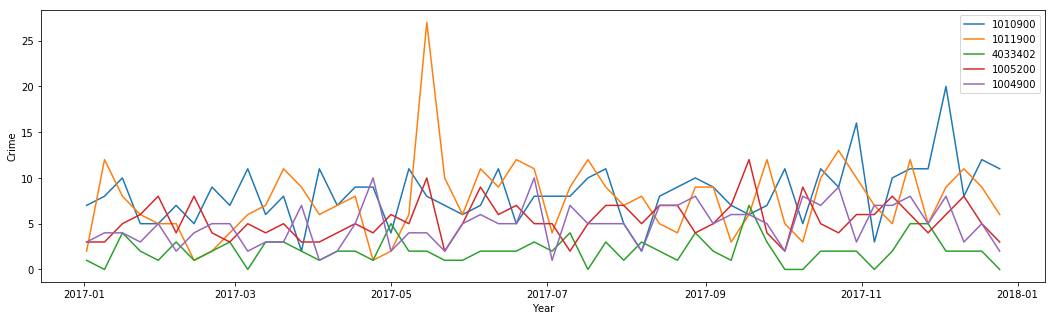

In [89]:
plt.figure(figsize=(18, 5))

plt.plot(crimeAll_weekly_data1.Date[-52:], crimeAll_weekly_data1['1010900'][-52:])
plt.plot(crimeAll_weekly_data1.Date[-52:], crimeAll_weekly_data1['1011900'][-52:])
plt.plot(crimeAll_weekly_data1.Date[-52:], crimeAll_weekly_data1['4033402'][-52:])
plt.plot(crimeAll_weekly_data1.Date[-52:], crimeAll_weekly_data1['1005200'][-52:])
plt.plot(crimeAll_weekly_data1.Date[-52:], crimeAll_weekly_data1['1004900'][-52:])

plt.xlabel("Year")
plt.ylabel("Crime")
#plt.title(title)
plt.legend()
plt.show()


In [218]:
# multivariate output data prep
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [78]:
np.array(crimeAll_weekly_data1['1010900'][-52:])

array([  7.,   8.,  10.,   5.,   5.,   7.,   5.,   9.,   7.,  11.,   6.,
         8.,   2.,  11.,   7.,   9.,   9.,   4.,  11.,   8.,   7.,   6.,
         7.,  11.,   5.,   8.,   8.,   8.,  10.,  11.,   5.,   2.,   8.,
         9.,  10.,   9.,   7.,   6.,   7.,  11.,   5.,  11.,   9.,  16.,
         3.,  10.,  11.,  11.,  20.,   8.,  12.,  11.])

In [108]:
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

(39, 13, 6) (39, 6)


In [109]:
# define input sequence
in_seq1 = np.array(crimeAll_weekly_data1['1010900'][-52:])
in_seq2 = np.array(crimeAll_weekly_data1['1011900'][-52:])
in_seq3 = np.array(crimeAll_weekly_data1['4033402'][-52:])
in_seq4 = np.array(crimeAll_weekly_data1['1005200'][-52:])
in_seq5 = np.array(crimeAll_weekly_data1['1004900'][-52:])
out_seq = array([in_seq1[i]+in_seq2[i]+in_seq3[i]+in_seq4[i]+in_seq5[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, out_seq))

# choose a number of time steps
n_steps = 13

# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

(39, 13, 6) (39, 6)
[[  7.   2.   1.   3.   3.  16.]
 [  8.  12.   0.   3.   4.  27.]
 [ 10.   8.   4.   5.   4.  31.]
 [  5.   6.   2.   6.   3.  22.]
 [  5.   5.   1.   8.   5.  24.]
 [  7.   5.   3.   4.   2.  21.]
 [  5.   1.   1.   8.   4.  19.]
 [  9.   2.   2.   4.   5.  22.]
 [  7.   4.   3.   3.   5.  22.]
 [ 11.   6.   0.   5.   2.  24.]
 [  6.   7.   3.   4.   3.  23.]
 [  8.  11.   3.   5.   3.  30.]
 [  2.   9.   2.   3.   7.  23.]] [ 11.   6.   1.   3.   1.  22.]
[[  8.  12.   0.   3.   4.  27.]
 [ 10.   8.   4.   5.   4.  31.]
 [  5.   6.   2.   6.   3.  22.]
 [  5.   5.   1.   8.   5.  24.]
 [  7.   5.   3.   4.   2.  21.]
 [  5.   1.   1.   8.   4.  19.]
 [  9.   2.   2.   4.   5.  22.]
 [  7.   4.   3.   3.   5.  22.]
 [ 11.   6.   0.   5.   2.  24.]
 [  6.   7.   3.   4.   3.  23.]
 [  8.  11.   3.   5.   3.  30.]
 [  2.   9.   2.   3.   7.  23.]
 [ 11.   6.   1.   3.   1.  22.]] [  7.   7.   2.   4.   2.  22.]
[[ 10.   8.   4.   5.   4.  31.]
 [  5.   6.   2.   6.  

In [ ]:
# the dataset knows the number of features, e.g. 5
n_steps = 13
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=10, verbose=0)

# demonstrate prediction
x_input = dataset[38:51]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

### Spliting data into Train and Test, go on with Global Active Power example

In [238]:
np.array(crimeAll_weekly_data1['1010900'][158:418])

array([  8.,  14.,   8.,   7.,  12.,   8.,   8.,  10.,  15.,   1.,  10.,
        15.,   6.,  14.,  12.,  10.,  16.,  13.,   9.,   3.,  11.,   7.,
         3.,   8.,  12.,   8.,  10.,  11.,   7.,  13.,  10.,   5.,   6.,
        14.,   3.,   8.,  13.,   7.,   9.,   9.,  12.,  10.,  11.,   8.,
         8.,  22.,  11.,   7.,  16.,  16.,  11.,   4.,   6.,  11.,   9.,
         3.,   8.,   7.,   4.,   8.,   6.,  12.,   4.,  12.,  15.,   7.,
         9.,  18.,   9.,   8.,   4.,   8.,   6.,  13.,   8.,  12.,   9.,
         6.,   9.,  14.,  11.,  10.,   7.,  13.,  13.,   6.,   9.,  11.,
         9.,  12.,  17.,   9.,  15.,   6.,   6.,  14.,   6.,  11.,  12.,
        28.,  13.,  15.,  17.,   6.,  12.,  10.,   7.,  10.,   6.,  18.,
         5.,  13.,   8.,  11.,   7.,  10.,  11.,   5.,   7.,   9.,   6.,
        12.,  10.,  11.,   8.,   8.,  14.,   8.,  10.,  12.,   8.,   8.,
        13.,   5.,  10.,   3.,  12.,   8.,  13.,  11.,  11.,   5.,  12.,
         6.,   7.,  18.,  12.,  13.,  12.,   9.,  1

In [239]:
np.array(crimeAll_weekly_data1['1010900'][-104:])

array([ 19.,  15.,  11.,  10.,   6.,   7.,   7.,   9.,   5.,  11.,  10.,
         9.,  10.,  12.,  11.,  12.,   7.,  10.,  11.,   6.,  14.,  12.,
         8.,   8.,  14.,  14.,   5.,   5.,   4.,   4.,  13.,   6.,   9.,
         6.,  11.,   7.,   7.,   8.,  10.,   4.,   6.,  10.,  11.,  10.,
        12.,   9.,  18.,  15.,  25.,   9.,  16.,  13.,   7.,   8.,  10.,
         5.,   5.,   7.,   5.,   9.,   7.,  11.,   6.,   8.,   2.,  11.,
         7.,   9.,   9.,   4.,  11.,   8.,   7.,   6.,   7.,  11.,   5.,
         8.,   8.,   8.,  10.,  11.,   5.,   2.,   8.,   9.,  10.,   9.,
         7.,   6.,   7.,  11.,   5.,  11.,   9.,  16.,   3.,  10.,  11.,
        11.,  20.,   8.,  12.,  11.])

In [170]:
# define train sequence
train_seq1 = np.array(crimeAll_weekly_data1['1010900'][158:418])
train_seq2 = np.array(crimeAll_weekly_data1['1011900'][158:418])
train_seq3 = np.array(crimeAll_weekly_data1['4033402'][158:418])
train_seq4 = np.array(crimeAll_weekly_data1['1005200'][158:418])
train_seq5 = np.array(crimeAll_weekly_data1['1004900'][158:418])
train_out_seq = array([train_seq1[i]+train_seq2[i]+train_seq3[i]+train_seq4[i]+train_seq5[i] 
                 for i in range(len(train_seq1))])

# convert to [rows, columns] structure
train_seq1 = train_seq1.reshape((len(train_seq1), 1))
train_seq2 = train_seq2.reshape((len(train_seq2), 1))
train_seq3 = train_seq3.reshape((len(train_seq3), 1))
train_seq4 = train_seq4.reshape((len(train_seq4), 1))
train_seq5 = train_seq5.reshape((len(train_seq5), 1))
train_out_seq = train_out_seq.reshape((len(train_out_seq), 1))

# horizontally stack columns
train_dataset = hstack((train_seq1, train_seq2, train_seq3, train_seq4, train_seq5, train_out_seq))

# choose a number of time steps
n_steps = 26
# convert into input/output
X_train, y_train = split_sequences(train_dataset, n_steps)
print(X_train.shape, y_train.shape)

# summarize the data
for i in range(len(X_train)):
    print(X_train[i], y_train[i])

(234, 26, 6) (234, 6)
[[  8.  10.   6.   5.   4.  33.]
 [ 14.  12.   7.   7.   1.  41.]
 [  8.   8.   7.   1.   3.  27.]
 [  7.   8.   6.   7.  11.  39.]
 [ 12.   2.   5.   6.   4.  29.]
 [  8.   4.   5.   4.   5.  26.]
 [  8.  11.  10.   5.  11.  45.]
 [ 10.   9.   8.   5.   5.  37.]
 [ 15.   8.   8.   5.   9.  45.]
 [  1.   7.   8.   6.   9.  31.]
 [ 10.   5.   4.   7.   8.  34.]
 [ 15.   4.   9.   3.   4.  35.]
 [  6.  13.  11.   6.   8.  44.]
 [ 14.   8.   9.   1.   6.  38.]
 [ 12.   7.   8.   6.   6.  39.]
 [ 10.  14.  12.   7.   8.  51.]
 [ 16.   8.   8.   6.   8.  46.]
 [ 13.   7.  10.   2.   7.  39.]
 [  9.   6.   9.   8.   6.  38.]
 [  3.  10.  11.   4.   3.  31.]
 [ 11.   5.   6.   3.   7.  32.]
 [  7.   5.  13.   9.   3.  37.]
 [  3.   3.  17.   6.   7.  36.]
 [  8.   9.  14.   6.   8.  45.]
 [ 12.   6.   8.   4.   5.  35.]
 [  8.   9.   7.   8.   3.  35.]] [ 10.  11.   8.   7.   7.  43.]
[[ 14.  12.   7.   7.   1.  41.]
 [  8.   8.   7.   1.   3.  27.]
 [  7.   8.   6.   7.

[[ 12.   4.  10.   6.   6.  38.]
 [  4.  10.  11.   7.   2.  34.]
 [ 12.   7.   4.   2.   9.  34.]
 [ 15.  11.   7.   3.   5.  41.]
 [  7.   5.   7.   8.   9.  36.]
 [  9.   6.  11.   5.   5.  36.]
 [ 18.   3.   8.   8.   8.  45.]
 [  9.   6.   5.   5.   2.  27.]
 [  8.   9.  10.   4.   5.  36.]
 [  4.   9.  12.   4.  10.  39.]
 [  8.   7.   9.   3.   6.  33.]
 [  6.   7.   8.   3.   9.  33.]
 [ 13.  10.  11.   5.   3.  42.]
 [  8.   5.   7.   4.   8.  32.]
 [ 12.  11.  16.   7.   8.  54.]
 [  9.  13.  10.  12.   6.  50.]
 [  6.  12.  13.   7.   7.  45.]
 [  9.   5.   6.   6.   6.  32.]
 [ 14.  15.   8.  10.   4.  51.]
 [ 11.  12.  13.   4.   3.  43.]
 [ 10.  11.   5.   6.  11.  43.]
 [  7.  17.  13.  10.  11.  58.]
 [ 13.  15.   9.   8.   7.  52.]
 [ 13.   8.   6.   9.   6.  42.]
 [  6.   9.   7.   5.  11.  38.]
 [  9.  16.   9.   2.  12.  48.]] [ 11.   6.  11.  11.   8.  47.]
[[  4.  10.  11.   7.   2.  34.]
 [ 12.   7.   4.   2.   9.  34.]
 [ 15.  11.   7.   3.   5.  41.]
 [  7.   5

 [ 13.   5.   7.   8.   6.  39.]] [ 11.  12.   2.   3.   8.  36.]
[[  7.   4.   2.   8.   3.  24.]
 [ 10.   6.   7.   4.  11.  38.]
 [ 11.   6.   2.   5.   5.  29.]
 [  5.  10.  11.   6.   7.  39.]
 [  7.   3.   6.   9.   7.  32.]
 [  9.   4.   4.   6.   5.  28.]
 [  6.   8.   8.   6.   6.  34.]
 [ 12.   9.   7.   4.   3.  35.]
 [ 10.   9.  10.   8.   4.  41.]
 [ 11.   4.   5.   5.   5.  30.]
 [  8.   3.   3.   9.   8.  31.]
 [  8.   7.   7.  10.   2.  34.]
 [ 14.   9.  11.   5.   4.  43.]
 [  8.  11.   9.   2.   3.  33.]
 [ 10.  13.   7.   4.   6.  40.]
 [ 12.  14.   3.   4.   5.  38.]
 [  8.  13.   7.   8.   7.  43.]
 [  8.  11.   6.   7.   5.  37.]
 [ 13.  15.   9.  13.  14.  64.]
 [  5.   8.   3.   8.   0.  24.]
 [ 10.  11.  11.   3.   1.  36.]
 [  3.   8.   4.   5.   5.  25.]
 [ 12.  16.   3.   8.   1.  40.]
 [  8.   6.   4.   9.   7.  34.]
 [ 13.   5.   7.   8.   6.  39.]
 [ 11.  12.   2.   3.   8.  36.]] [ 11.   7.   2.   2.   4.  26.]
[[ 10.   6.   7.   4.  11.  38.]
 [ 11.   6

[[ 11.  12.   7.   9.   5.  44.]
 [  7.  12.   9.   8.   3.  39.]
 [ 12.   9.   9.   5.   6.  41.]
 [  7.   7.  15.   5.   4.  38.]
 [  5.   5.   8.   6.   4.  28.]
 [  6.  20.  16.   9.   2.  53.]
 [  9.   6.  14.  12.   6.  47.]
 [  8.  12.   9.   4.   3.  36.]
 [ 13.  16.   8.   4.   5.  46.]
 [ 12.  13.   6.   6.   2.  39.]
 [  6.   4.   4.   9.   5.  28.]
 [ 10.  10.   3.   4.   6.  33.]
 [  6.   9.   8.   3.   6.  32.]
 [ 10.   9.   4.   3.   4.  30.]
 [ 12.   6.   6.   6.  10.  40.]
 [ 14.  15.  10.   1.   9.  49.]
 [ 11.   9.  10.   4.   7.  41.]
 [ 14.  11.   7.   2.   3.  37.]
 [ 17.  14.   9.   7.  14.  61.]
 [ 18.  12.  11.   3.   4.  48.]
 [ 10.  13.   5.   0.  10.  38.]
 [ 10.  10.   6.   6.   4.  36.]
 [  8.   4.   4.   5.   8.  29.]
 [  6.  10.   8.   7.   7.  38.]
 [  6.  10.   4.   5.   6.  31.]
 [  5.   6.  13.   4.   2.  30.]] [  8.   9.   7.   5.   1.  30.]
[[  7.  12.   9.   8.   3.  39.]
 [ 12.   9.   9.   5.   6.  41.]
 [  7.   7.  15.   5.   4.  38.]
 [  5.   5

In [171]:
# define test sequence
test_seq1 = np.array(crimeAll_weekly_data1['1010900'][-104:])
test_seq2 = np.array(crimeAll_weekly_data1['1011900'][-104:])
test_seq3 = np.array(crimeAll_weekly_data1['4033402'][-104:])
test_seq4 = np.array(crimeAll_weekly_data1['1005200'][-104:])
test_seq5 = np.array(crimeAll_weekly_data1['1004900'][-104:])
test_out_seq = array([test_seq1[i]+test_seq2[i]+test_seq3[i]+test_seq4[i]+test_seq5[i] 
                 for i in range(len(test_seq1))])

# convert to [rows, columns] structure
test_seq1 = test_seq1.reshape((len(test_seq1), 1))
test_seq2 = test_seq2.reshape((len(test_seq2), 1))
test_seq3 = test_seq3.reshape((len(test_seq3), 1))
test_seq4 = test_seq4.reshape((len(test_seq4), 1))
test_seq5 = test_seq5.reshape((len(test_seq5), 1))
test_out_seq = test_out_seq.reshape((len(test_out_seq), 1))

# horizontally stack columns
test_dataset = hstack((test_seq1, test_seq2, test_seq3, test_seq4, test_seq5, test_out_seq))

# choose a number of time steps
n_steps = 26
# convert into input/output
X_test, y_test = split_sequences(test_dataset, n_steps)
print(X_test.shape, y_test.shape)

# summarize the data
for i in range(len(X_test)):
    print(X_test[i], y_test[i])

(78, 26, 6) (78, 6)
[[ 19.   6.   6.   4.   5.  40.]
 [ 15.  13.   3.   3.   4.  38.]
 [ 11.   5.   2.   6.   6.  30.]
 [ 10.   9.   3.   6.   4.  32.]
 [  6.  11.   2.   2.   5.  26.]
 [  7.   6.   1.  10.   4.  28.]
 [  7.   9.   1.   4.   4.  25.]
 [  9.   5.   1.   5.   6.  26.]
 [  5.   7.   0.   6.   6.  24.]
 [ 11.   5.   0.   6.   6.  28.]
 [ 10.   7.   1.   3.   4.  25.]
 [  9.   6.   4.   4.   4.  27.]
 [ 10.   7.   1.   2.   2.  22.]
 [ 12.   6.   2.   3.   2.  25.]
 [ 11.   8.   0.   9.   7.  35.]
 [ 12.   5.   2.   6.   3.  28.]
 [  7.  12.   4.   1.   1.  25.]
 [ 10.   6.   3.   7.   1.  27.]
 [ 11.   8.   5.   5.   5.  34.]
 [  6.   8.   0.   9.   6.  29.]
 [ 14.   9.   2.   7.   5.  37.]
 [ 12.  11.   1.   5.   5.  34.]
 [  8.   7.   2.   3.   4.  24.]
 [  8.   9.   3.   6.   7.  33.]
 [ 14.  12.   4.   5.   4.  39.]
 [ 14.   6.   4.   5.   5.  34.]] [  5.   9.   4.   7.   5.  30.]
[[ 15.  13.   3.   3.   4.  38.]
 [ 11.   5.   2.   6.   6.  30.]
 [ 10.   9.   3.   6.  

[[  8.   9.   3.   6.   7.  33.]
 [ 14.  12.   4.   5.   4.  39.]
 [ 14.   6.   4.   5.   5.  34.]
 [  5.   9.   4.   7.   5.  30.]
 [  5.   3.   8.   5.   6.  27.]
 [  4.   8.   0.   8.   4.  24.]
 [  4.   9.   7.   6.   5.  31.]
 [ 13.   9.   0.   1.   5.  28.]
 [  6.   6.   2.   3.   5.  22.]
 [  9.  11.   2.   7.   5.  34.]
 [  6.  16.   0.   5.   6.  33.]
 [ 11.  12.   1.  10.   6.  40.]
 [  7.  10.   2.   9.   5.  33.]
 [  7.   7.   3.   7.   9.  33.]
 [  8.   9.   5.   5.   5.  32.]
 [ 10.   3.   5.   2.   7.  27.]
 [  4.   5.   3.   2.   9.  23.]
 [  6.  13.   3.  10.   4.  36.]
 [ 10.   9.   2.   4.   1.  26.]
 [ 11.  12.   2.   5.   5.  35.]
 [ 10.  11.   2.   4.   5.  32.]
 [ 12.   9.   3.   6.   5.  35.]
 [  9.   4.   3.   6.   3.  25.]
 [ 18.  11.   0.   6.   7.  42.]
 [ 15.   9.   6.   4.   3.  37.]
 [ 25.   9.   6.   9.   6.  55.]] [  9.   9.   3.   4.   4.  29.]
[[ 14.  12.   4.   5.   4.  39.]
 [ 14.   6.   4.   5.   5.  34.]
 [  5.   9.   4.   7.   5.  30.]
 [  5.   3

#### Rearranging the dataset

In [179]:
crimeAll_weekly_data1.values

array([[Timestamp('2007-12-31 00:00:00'), 6.0, 16.0, 7.0, 9.0, 6.0],
       [Timestamp('2008-01-07 00:00:00'), 21.0, 9.0, 2.0, 10.0, 10.0],
       [Timestamp('2008-01-14 00:00:00'), 14.0, 7.0, 4.0, 5.0, 9.0],
       ..., 
       [Timestamp('2017-12-11 00:00:00'), 8.0, 11.0, 2.0, 8.0, 3.0],
       [Timestamp('2017-12-18 00:00:00'), 12.0, 9.0, 2.0, 5.0, 5.0],
       [Timestamp('2017-12-25 00:00:00'), 11.0, 6.0, 0.0, 3.0, 2.0]], dtype=object)

In [ ]:
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#### Training the model

In [181]:
# the dataset knows the number of features, e.g. 5
n_steps = 26
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 26, 100)           42800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 606       
Total params: 123,806
Trainable params: 123,806
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### check this out for our 6 features version

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

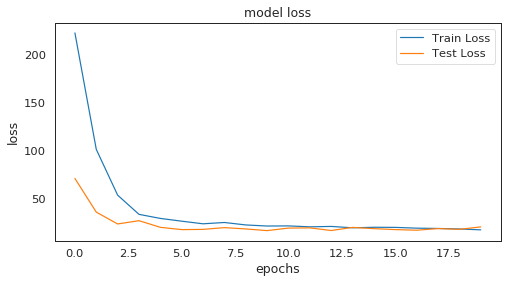

In [187]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

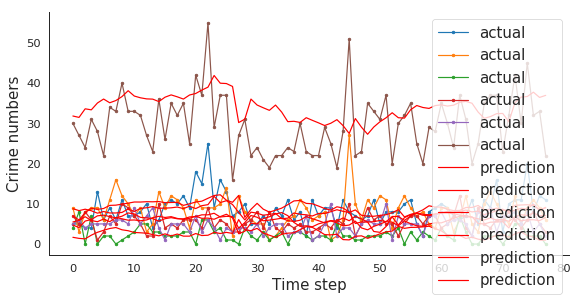

In [205]:
aa=[x for x in range(78)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test, marker='.', label="actual")
plt.plot(aa, test_predict[:,], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Crime numbers', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

### Multiple series with clustered dataframe

In [206]:
df_clustered = pd.read_csv('df_clustered')

In [213]:
df_clustered = df_clustered.rename(index=str, columns={"Unnamed: 0": "Date"})

In [214]:
df_clustered['Date'] = pd.to_datetime(df_clustered['Date'])

In [267]:
df_clustered[-10:]

,Date,Label0,Label1,Label2,Label3,Label4
512,2017-10-23,295.0000,267.0000,467.0000,450.0000,418.0000
513,2017-10-30,284.0000,291.0000,515.0000,409.0000,435.0000
514,2017-11-06,269.0000,324.0000,410.0000,378.0000,402.0000
515,2017-11-13,275.0000,262.0000,436.0000,341.0000,436.0000
516,2017-11-20,251.0000,261.0000,463.0000,400.0000,399.0000
517,2017-11-27,262.0000,244.0000,450.0000,384.0000,434.0000
518,2017-12-04,248.0000,229.0000,450.0000,429.0000,369.0000
519,2017-12-11,264.0000,284.0000,420.0000,345.0000,402.0000
520,2017-12-18,245.0000,214.0000,369.0000,383.0000,402.0000
521,2017-12-25,145.0000,142.0000,228.0000,237.0000,253.0000


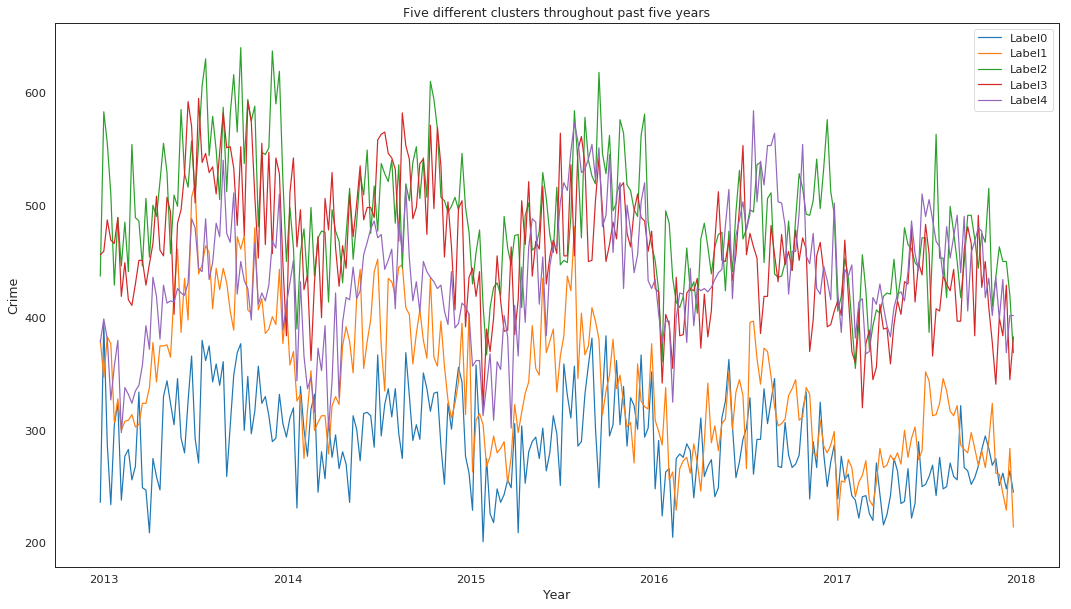

In [318]:
plt.figure(figsize=(18, 10))

plt.plot(df_clustered.Date[260:521], df_clustered['Label0'][260:521])
plt.plot(df_clustered.Date[260:521], df_clustered['Label1'][260:521])
plt.plot(df_clustered.Date[260:521], df_clustered['Label2'][260:521])
plt.plot(df_clustered.Date[260:521], df_clustered['Label3'][260:521])
plt.plot(df_clustered.Date[260:521], df_clustered['Label4'][260:521])

plt.xlabel("Year")
plt.ylabel("Crime")
plt.title("Five different clusters throughout past five years")
plt.legend()
plt.show()

In [299]:
# define train sequence
train_seq1 = np.array(df_clustered['Label0'][104:365])
train_seq2 = np.array(df_clustered['Label1'][104:365])
train_seq3 = np.array(df_clustered['Label2'][104:365])
train_seq4 = np.array(df_clustered['Label3'][104:365])
train_seq5 = np.array(df_clustered['Label4'][104:365])
train_out_seq = array([train_seq1[i]+train_seq2[i]+train_seq3[i]+train_seq4[i]+train_seq5[i] 
                 for i in range(len(train_seq1))])

# convert to [rows, columns] structure
train_seq1 = train_seq1.reshape((len(train_seq1), 1))
train_seq2 = train_seq2.reshape((len(train_seq2), 1))
train_seq3 = train_seq3.reshape((len(train_seq3), 1))
train_seq4 = train_seq4.reshape((len(train_seq4), 1))
train_seq5 = train_seq5.reshape((len(train_seq5), 1))
train_out_seq = train_out_seq.reshape((len(train_out_seq), 1))

# horizontally stack columns
train_dataset = hstack((train_seq1, train_seq2, train_seq3, train_seq4, train_seq5, train_out_seq))

# choose a number of time steps
n_steps = 52
# convert into input/output
X_train, y_train = split_sequences(train_dataset, n_steps)
print(X_train.shape, y_train.shape)

# summarize the data
for i in range(len(X_train)):
    print(X_train[i], y_train[i])

(209, 52, 6) (209, 6)
[[  310.   337.   581.   496.   385.  2109.]
 [  298.   318.   588.   477.   281.  1962.]
 [  292.   324.   664.   458.   317.  2055.]
 [  319.   311.   663.   477.   327.  2097.]
 [  266.   284.   496.   440.   329.  1815.]
 [  290.   249.   510.   410.   312.  1771.]
 [  229.   234.   490.   381.   248.  1582.]
 [  245.   248.   546.   377.   276.  1692.]
 [  247.   289.   445.   406.   300.  1687.]
 [  257.   294.   508.   479.   325.  1863.]
 [  221.   259.   518.   528.   267.  1793.]
 [  316.   320.   585.   448.   295.  1964.]
 [  299.   335.   585.   374.   305.  1898.]
 [  244.   285.   546.   476.   273.  1824.]
 [  269.   281.   542.   482.   345.  1919.]
 [  269.   361.   557.   468.   309.  1964.]
 [  316.   317.   535.   399.   309.  1876.]
 [  312.   346.   549.   446.   356.  2009.]
 [  302.   323.   624.   472.   330.  2051.]
 [  265.   295.   540.   532.   343.  1975.]
 [  278.   304.   593.   533.   341.  2049.]
 [  288.   314.   570.   561.   3

[[  343.   400.   567.   512.   400.  2222.]
 [  321.   433.   606.   528.   396.  2284.]
 [  300.   371.   557.   464.   353.  2045.]
 [  321.   386.   629.   464.   353.  2153.]
 [  253.   373.   632.   489.   363.  2110.]
 [  305.   420.   578.   501.   396.  2200.]
 [  353.   396.   602.   469.   387.  2207.]
 [  288.   349.   624.   485.   380.  2126.]
 [  317.   362.   603.   477.   387.  2146.]
 [  304.   496.   659.   558.   398.  2415.]
 [  313.   406.   619.   582.   365.  2285.]
 [  314.   351.   557.   571.   365.  2158.]
 [  380.   336.   601.   523.   383.  2223.]
 [  323.   401.   679.   486.   376.  2265.]
 [  374.   369.   657.   586.   383.  2369.]
 [  273.   351.   587.   556.   325.  2092.]
 [  266.   325.   698.   533.   378.  2200.]
 [  304.   349.   634.   571.   387.  2245.]
 [  257.   354.   593.   524.   307.  2035.]
 [  278.   367.   625.   567.   349.  2186.]
 [  279.   317.   638.   495.   350.  2079.]
 [  319.   356.   646.   487.   349.  2157.]
 [  248.  

 [  329.   332.   511.   486.   346.  2004.]] [  280.   321.   493.   456.   332.  1882.]
[[  299.   285.   473.   444.   292.  1793.]
 [  224.   264.   467.   402.   327.  1684.]
 [  275.   297.   438.   462.   294.  1766.]
 [  258.   294.   533.   494.   321.  1900.]
 [  242.   327.   476.   496.   334.  1875.]
 [  285.   257.   482.   484.   362.  1870.]
 [  241.   305.   465.   518.   372.  1901.]
 [  261.   326.   572.   461.   326.  1946.]
 [  294.   302.   547.   456.   318.  1917.]
 [  261.   311.   464.   408.   328.  1772.]
 [  284.   386.   581.   465.   337.  2053.]
 [  309.   392.   535.   446.   379.  2061.]
 [  316.   398.   497.   529.   371.  2111.]
 [  274.   358.   573.   497.   365.  2067.]
 [  283.   415.   542.   496.   357.  2093.]
 [  292.   397.   555.   539.   352.  2135.]
 [  297.   392.   554.   476.   350.  2069.]
 [  331.   408.   585.   479.   342.  2145.]
 [  332.   444.   554.   545.   380.  2255.]
 [  314.   513.   557.   506.   372.  2262.]
 [  290.  

[[  325.   362.   505.   540.   361.  2093.]
 [  305.   441.   591.   467.   417.  2221.]
 [  348.   453.   592.   566.   415.  2374.]
 [  286.   416.   640.   521.   420.  2283.]
 [  288.   385.   537.   506.   367.  2083.]
 [  351.   380.   540.   611.   407.  2289.]
 [  293.   324.   665.   564.   392.  2238.]
 [  259.   366.   679.   598.   338.  2240.]
 [  257.   376.   618.   600.   364.  2215.]
 [  315.   324.   557.   576.   306.  2078.]
 [  309.   323.   561.   595.   390.  2178.]
 [  292.   357.   606.   593.   432.  2280.]
 [  344.   364.   578.   563.   386.  2235.]
 [  295.   379.   592.   526.   354.  2146.]
 [  353.   388.   636.   480.   379.  2236.]
 [  348.   388.   577.   550.   333.  2196.]
 [  338.   345.   599.   511.   414.  2207.]
 [  317.   342.   527.   440.   331.  1957.]
 [  281.   321.   499.   432.   323.  1856.]
 [  265.   338.   547.   470.   343.  1963.]
 [  304.   315.   605.   504.   346.  2074.]
 [  329.   332.   511.   486.   346.  2004.]
 [  280.  

[[  308.   362.   455.   474.   340.  1939.]
 [  285.   423.   493.   419.   356.  1976.]
 [  268.   344.   468.   484.   375.  1939.]
 [  282.   343.   497.   509.   348.  1979.]
 [  292.   358.   489.   487.   416.  2042.]
 [  286.   419.   662.   514.   366.  2247.]
 [  289.   363.   515.   582.   417.  2166.]
 [  267.   432.   600.   507.   409.  2215.]
 [  302.   451.   501.   555.   402.  2211.]
 [  341.   400.   526.   559.   441.  2267.]
 [  280.   370.   531.   556.   446.  2183.]
 [  336.   419.   631.   508.   447.  2341.]
 [  378.   417.   597.   530.   458.  2380.]
 [  274.   423.   632.   555.   482.  2366.]
 [  310.   471.   542.   585.   430.  2338.]
 [  351.   418.   550.   489.   472.  2280.]
 [  346.   462.   576.   488.   466.  2338.]
 [  337.   431.   538.   563.   468.  2337.]
 [  350.   463.   571.   553.   460.  2397.]
 [  296.   464.   617.   610.   463.  2450.]
 [  320.   484.   540.   538.   460.  2342.]
 [  328.   431.   559.   550.   416.  2284.]
 [  342.  

[[  299.   364.   586.   595.   444.  2288.]
 [  331.   437.   552.   484.   461.  2265.]
 [  256.   375.   497.   436.   446.  2010.]
 [  270.   366.   578.   478.   372.  2064.]
 [  328.   367.   581.   574.   431.  2281.]
 [  307.   398.   600.   481.   399.  2185.]
 [  319.   410.   583.   490.   455.  2257.]
 [  336.   430.   617.   495.   383.  2261.]
 [  361.   364.   589.   585.   404.  2303.]
 [  295.   387.   642.   594.   398.  2316.]
 [  236.   380.   437.   456.   378.  1887.]
 [  395.   347.   583.   459.   399.  2183.]
 [  287.   383.   555.   487.   381.  2093.]
 [  234.   377.   510.   469.   327.  1917.]
 [  305.   307.   429.   466.   357.  1864.]
 [  324.   328.   489.   489.   380.  2010.]
 [  238.   300.   446.   419.   298.  1701.]
 [  277.   308.   485.   449.   338.  1857.]
 [  283.   309.   441.   416.   332.  1781.]
 [  256.   314.   554.   411.   324.  1859.]
 [  268.   303.   489.   430.   335.  1825.]
 [  334.   305.   486.   451.   340.  1916.]
 [  249.  

[[  259.   343.   490.   508.   419.  2019.]
 [  247.   375.   521.   460.   381.  1984.]
 [  330.   375.   555.   455.   429.  2144.]
 [  344.   376.   529.   507.   413.  2169.]
 [  324.   365.   457.   494.   415.  2055.]
 [  305.   422.   509.   403.   414.  2053.]
 [  346.   461.   499.   484.   426.  2216.]
 [  293.   387.   585.   496.   422.  2183.]
 [  280.   435.   528.   528.   420.  2191.]
 [  326.   398.   516.   592.   431.  2263.]
 [  366.   507.   557.   570.   488.  2488.]
 [  293.   519.   508.   502.   480.  2302.]
 [  271.   439.   555.   595.   444.  2304.]
 [  380.   447.   606.   538.   441.  2412.]
 [  362.   464.   630.   546.   488.  2490.]
 [  375.   458.   544.   529.   434.  2340.]
 [  343.   408.   579.   534.   449.  2313.]
 [  359.   444.   549.   510.   484.  2346.]
 [  340.   425.   505.   547.   472.  2289.]
 [  361.   444.   587.   582.   540.  2514.]
 [  259.   431.   512.   551.   475.  2228.]
 [  304.   406.   581.   552.   467.  2310.]
 [  349.  

[[  357.   407.   481.   453.   412.  2110.]
 [  324.   417.   547.   555.   422.  2265.]
 [  330.   386.   545.   465.   415.  2141.]
 [  313.   390.   551.   547.   429.  2230.]
 [  290.   401.   637.   457.   468.  2253.]
 [  293.   394.   590.   542.   462.  2281.]
 [  332.   443.   619.   528.   510.  2432.]
 [  306.   377.   522.   448.   389.  2042.]
 [  294.   412.   450.   384.   412.  1952.]
 [  311.   358.   498.   511.   431.  2109.]
 [  320.   370.   462.   542.   451.  2145.]
 [  231.   326.   390.   463.   344.  1754.]
 [  339.   332.   458.   496.   432.  2057.]
 [  301.   275.   479.   425.   366.  1846.]
 [  277.   318.   432.   438.   337.  1802.]
 [  319.   353.   498.   362.   347.  1879.]
 [  332.   300.   437.   432.   316.  1817.]
 [  245.   307.   471.   472.   373.  1868.]
 [  281.   313.   477.   400.   353.  1824.]
 [  257.   313.   476.   506.   393.  1945.]
 [  308.   279.   414.   478.   301.  1780.]
 [  276.   322.   496.   529.   344.  1967.]
 [  296.  

In [300]:
# define test sequence
test_seq1 = np.array(df_clustered['Label0'][365:521])
test_seq2 = np.array(df_clustered['Label1'][365:521])
test_seq3 = np.array(df_clustered['Label2'][365:521])
test_seq4 = np.array(df_clustered['Label3'][365:521])
test_seq5 = np.array(df_clustered['Label4'][365:521])
test_out_seq = array([test_seq1[i]+test_seq2[i]+test_seq3[i]+test_seq4[i]+test_seq5[i] 
                 for i in range(len(test_seq1))])

# convert to [rows, columns] structure
test_seq1 = test_seq1.reshape((len(test_seq1), 1))
test_seq2 = test_seq2.reshape((len(test_seq2), 1))
test_seq3 = test_seq3.reshape((len(test_seq3), 1))
test_seq4 = test_seq4.reshape((len(test_seq4), 1))
test_seq5 = test_seq5.reshape((len(test_seq5), 1))
test_out_seq = test_out_seq.reshape((len(test_out_seq), 1))

# horizontally stack columns
test_dataset = hstack((test_seq1, test_seq2, test_seq3, test_seq4, test_seq5, test_out_seq))

# choose a number of time steps
n_steps = 52
# convert into input/output
X_test, y_test = split_sequences(test_dataset, n_steps)
print(X_test.shape, y_test.shape)

# summarize the data
for i in range(len(X_test)):
    print(X_test[i], y_test[i])

(104, 52, 6) (104, 6)
[[  262.   404.   476.   436.   403.  1981.]
 [  229.   263.   430.   444.   357.  1723.]
 [  358.   309.   458.   419.   362.  1906.]
 [  297.   315.   478.   441.   362.  1893.]
 [  201.   305.   411.   318.   313.  1548.]
 [  275.   268.   367.   390.   340.  1640.]
 [  226.   277.   409.   370.   368.  1650.]
 [  218.   295.   427.   400.   309.  1649.]
 [  248.   280.   431.   455.   361.  1775.]
 [  236.   284.   420.   415.   354.  1709.]
 [  243.   290.   490.   388.   402.  1813.]
 [  256.   253.   462.   389.   383.  1743.]
 [  249.   276.   447.   463.   302.  1737.]
 [  306.   323.   473.   385.   411.  1898.]
 [  209.   298.   474.   416.   366.  1763.]
 [  304.   316.   409.   504.   445.  1978.]
 [  253.   333.   491.   465.   396.  1938.]
 [  281.   343.   502.   521.   463.  2110.]
 [  290.   393.   460.   437.   488.  2068.]
 [  294.   355.   463.   468.   485.  2065.]
 [  275.   349.   477.   461.   412.  1974.]
 [  302.   435.   529.   517.   4

[[  311.   424.   490.   536.   548.  2309.]
 [  357.   481.   584.   455.   573.  2450.]
 [  286.   346.   538.   549.   557.  2276.]
 [  290.   404.   471.   561.   529.  2255.]
 [  332.   367.   578.   537.   532.  2346.]
 [  358.   375.   540.   450.   541.  2264.]
 [  382.   409.   526.   451.   554.  2322.]
 [  302.   397.   519.   504.   523.  2245.]
 [  249.   381.   618.   542.   551.  2341.]
 [  330.   314.   546.   495.   481.  2166.]
 [  384.   335.   528.   450.   491.  2188.]
 [  295.   349.   562.   465.   545.  2216.]
 [  305.   381.   495.   485.   458.  2124.]
 [  362.   337.   502.   470.   509.  2180.]
 [  305.   349.   576.   516.   520.  2266.]
 [  339.   324.   564.   520.   426.  2173.]
 [  286.   303.   518.   475.   500.  2082.]
 [  329.   307.   513.   463.   477.  2089.]
 [  322.   271.   496.   495.   440.  2024.]
 [  301.   359.   490.   510.   456.  2116.]
 [  367.   326.   562.   489.   503.  2247.]
 [  294.   321.   581.   486.   520.  2202.]
 [  302.  

[[  291.   299.   424.   423.   403.  1840.]
 [  224.   287.   361.   342.   378.  1592.]
 [  263.   338.   495.   403.   397.  1896.]
 [  266.   256.   484.   394.   397.  1797.]
 [  205.   263.   435.   355.   325.  1583.]
 [  275.   229.   414.   436.   400.  1754.]
 [  279.   266.   409.   384.   422.  1760.]
 [  276.   273.   419.   385.   421.  1774.]
 [  288.   276.   462.   422.   378.  1826.]
 [  282.   262.   424.   426.   444.  1838.]
 [  240.   288.   432.   424.   393.  1777.]
 [  274.   271.   404.   435.   427.  1811.]
 [  311.   246.   470.   373.   424.  1824.]
 [  259.   290.   484.   421.   426.  1880.]
 [  268.   342.   463.   383.   423.  1879.]
 [  274.   289.   439.   406.   427.  1835.]
 [  241.   304.   463.   469.   434.  1911.]
 [  249.   282.   474.   512.   440.  1957.]
 [  311.   306.   476.   451.   443.  1987.]
 [  326.   310.   424.   450.   482.  1992.]
 [  363.   352.   477.   469.   514.  2175.]
 [  304.   301.   441.   433.   417.  1896.]
 [  258.  

[[  337.   373.   449.   419.   518.  2096.]
 [  306.   370.   506.   419.   553.  2154.]
 [  326.   348.   511.   482.   553.  2220.]
 [  346.   321.   439.   456.   564.  2126.]
 [  268.   304.   436.   432.   503.  1943.]
 [  267.   306.   437.   474.   502.  1986.]
 [  307.   310.   449.   447.   482.  1995.]
 [  278.   331.   486.   459.   421.  1975.]
 [  267.   337.   442.   442.   459.  1947.]
 [  270.   345.   488.   478.   459.  2040.]
 [  278.   309.   528.   451.   493.  2059.]
 [  318.   312.   515.   471.   554.  2170.]
 [  334.   338.   492.   461.   455.  2080.]
 [  239.   332.   491.   370.   448.  1880.]
 [  290.   280.   504.   398.   475.  1947.]
 [  267.   277.   541.   455.   426.  1966.]
 [  325.   309.   497.   467.   421.  2019.]
 [  279.   286.   533.   441.   446.  1985.]
 [  250.   280.   576.   392.   433.  1931.]
 [  272.   287.   512.   394.   416.  1881.]
 [  287.   299.   492.   406.   502.  1986.]
 [  239.   220.   406.   415.   423.  1703.]
 [  277.  

In [323]:
X_test.shape

(104, 52, 6)

#### Train the model

In [311]:
# the dataset knows the number of features, e.g. 5
n_steps = 52
n_features = X_train.shape[2]

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)